In [6]:
# import libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import pathlib

In [7]:
# importing dataset
dataset_dir = '../PlantVillage'

In [8]:
#Global initialization of some imp variables
Image_Size = 256
Batch_Size = 32
Channels = 3
Epochs = 40

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    batch_size=Batch_Size,
    image_size=(Image_Size, Image_Size),
    shuffle=True
)

Found 2152 files belonging to 3 classes.


In [10]:
#Folders(classes) in 'Dataset' directory
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
len(dataset) # Number of Batches = (total number of files belonging to all classes / Batch_Size)

68

In [12]:
print(dataset) #prints Elements in dataset: here 1st element is image and 2nd index of that image.

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


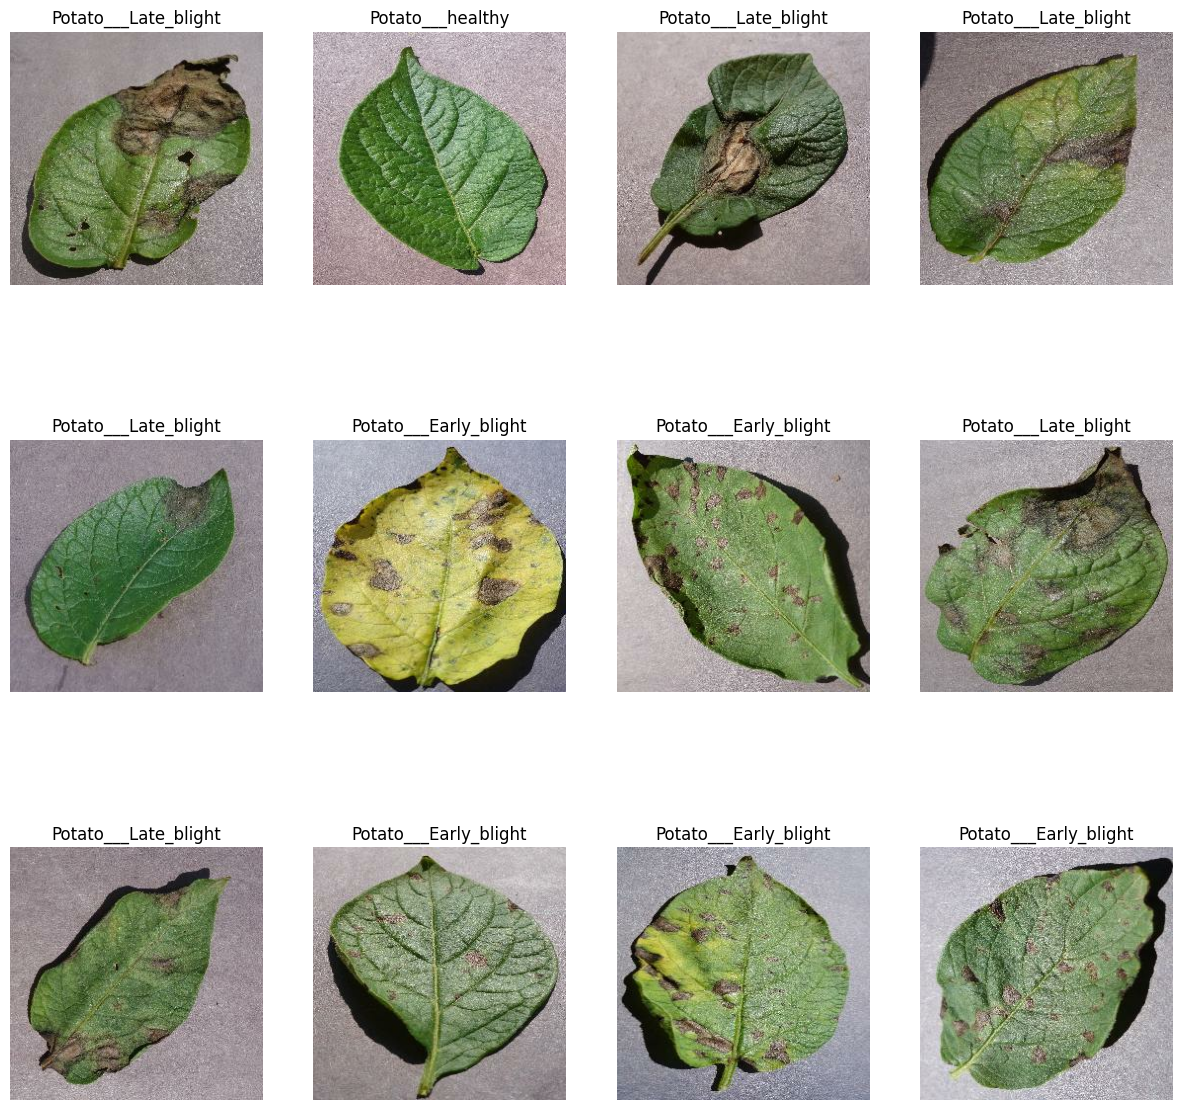

In [13]:
# Plotting the image
plt.figure(figsize = (15,15))
# dataset.take(count) : Creates a Dataset with at most 'count' elements(batch) from the dataset
for image, label in dataset.take(1): 
    for i in range(12):
        plt.subplot(3, 4, i+1) # many plots at a time =>subpots
        plt.imshow(image[i].numpy().astype('uint8')) #converting all data of image into numpy and than to intiger type as they were in float.
        plt.title(class_name[label[i]])  # title of the class_name of image
        plt.axis("off") # Hide the values of graph
        

In [58]:
def get_dataset_size(ds):
    count = 0
    for _ in ds:
        count += 1
    return count

In [14]:
# Function for Splitting the data
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 10)
        
    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_data, val_data, test_data = split_dataset(dataset)

In [16]:
print("Size of Data is :{0} \nBatch size of Training Data is :{1}\nBatch size of Validation Data is :{2} \nBatch size of Testing Data is :{3} " .format(len(dataset), len(train_data), len(val_data), len(test_data)))

Size of Data is :68 
Batch size of Training Data is :54
Batch size of Validation Data is :6 
Batch size of Testing Data is :8 


In [17]:
# caching,shuffle and prefetching the data
train_ds = train_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_data.cache().shuffle(100).prefetch(buffer_size = tf.data.AUTOTUNE)

In [18]:
# Image Preprocessing : Rescaling and Resizing
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(Image_Size, Image_Size),
    layers.Rescaling(1./255)
])

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip(mode="horizontal_and_vertical"),
    layers.RandomRotation(factor=0.5)
])

In [20]:
# Creating Convolution layer 
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(filters = 16, kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(64, activation = 'softmax'),

])


model.build(input_shape = input_shape)

C:\Users\BSOK AKU\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 128)              │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 64)               │         8,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,176 (1.32 MB)

 Trainable params: 346,176 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Optimizing the model 'SparseCategoricalCrossentropy'=>as there are many categorical classes of data
model.compile(
    optimizer = 'adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), 
    metrics = ['accuracy'])

In [23]:
#Fit the model with training data and also pass validation data
history = model.fit(
train_data, epochs = Epochs, batch_size = Batch_Size, verbose = 1, validation_data = val_data)

Epoch 1/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 593ms/step - accuracy: 0.3772 - loss: 1.8175 - val_accuracy: 0.4844 - val_loss: 0.9452
Epoch 2/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 653ms/step - accuracy: 0.5394 - loss: 0.8646 - val_accuracy: 0.5521 - val_loss: 0.8493
Epoch 3/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 37s 671ms/step - accuracy: 0.6173 - loss: 0.8165 - val_accuracy: 0.7448 - val_loss: 0.5894
Epoch 4/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 717ms/step - accuracy: 0.7833 - loss: 0.5487 - val_accuracy: 0.7604 - val_loss: 0.5176
Epoch 5/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 752ms/step - accuracy: 0.8392 - loss: 0.4225 - val_accuracy: 0.8929 - val_loss: 0.2822
Epoch 6/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.8772 - loss: 0.3265 - val_accuracy: 0.8854 - val_loss: 0.3039
Epoch 7/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 662ms/step - accuracy: 0.8608 - loss: 0.3057 - val_accuracy: 0.8854 - val_loss: 0.2778
Epoch 8/40
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 649ms/step - accuracy: 0.8904 - loss: 0.2665 - val_accurac

In [24]:
scores = model.evaluate(train_data)

54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 170ms/step - accuracy: 0.9789 - loss: 0.0629


In [25]:
history

In [26]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 54}

In [27]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [28]:
# Getting the model history to analyse
train_loss = history.history['loss']
train_acc = history.history['accuracy']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

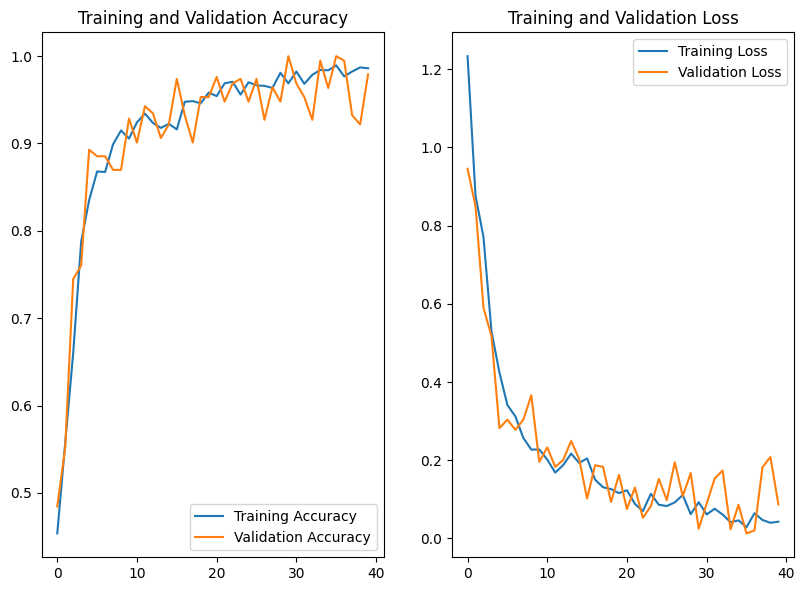

In [29]:
#graphs for accuracy and loss of training and validation data
plt.figure(figsize = (15,15))
plt.subplot(2,3,1)
plt.plot(range(Epochs), train_acc, label = 'Training Accuracy')
plt.plot(range(Epochs), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy') 

plt.subplot(2,3,2)
plt.plot(range(Epochs), train_loss, label = 'Training Loss')
plt.plot(range(Epochs), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

First Image of batch to predict :
Actual label :  Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
Predicted label :  Potato___Early_blight


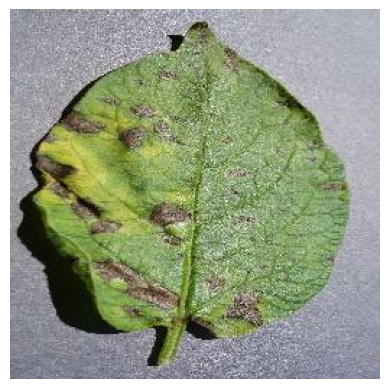

In [30]:
#plotting image
for batch_image, batch_label in train_data.take(1):
    first_image = batch_image[0].numpy().astype('uint8')
    first_label = class_name[batch_label[0]]
    
    print('First Image of batch to predict :')
    plt.imshow(first_image)
    print('Actual label : ', first_label)
    
    batch_prediction = model.predict(batch_image)
    print('Predicted label : ', class_name[np.argmax(batch_prediction[0])])
    plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


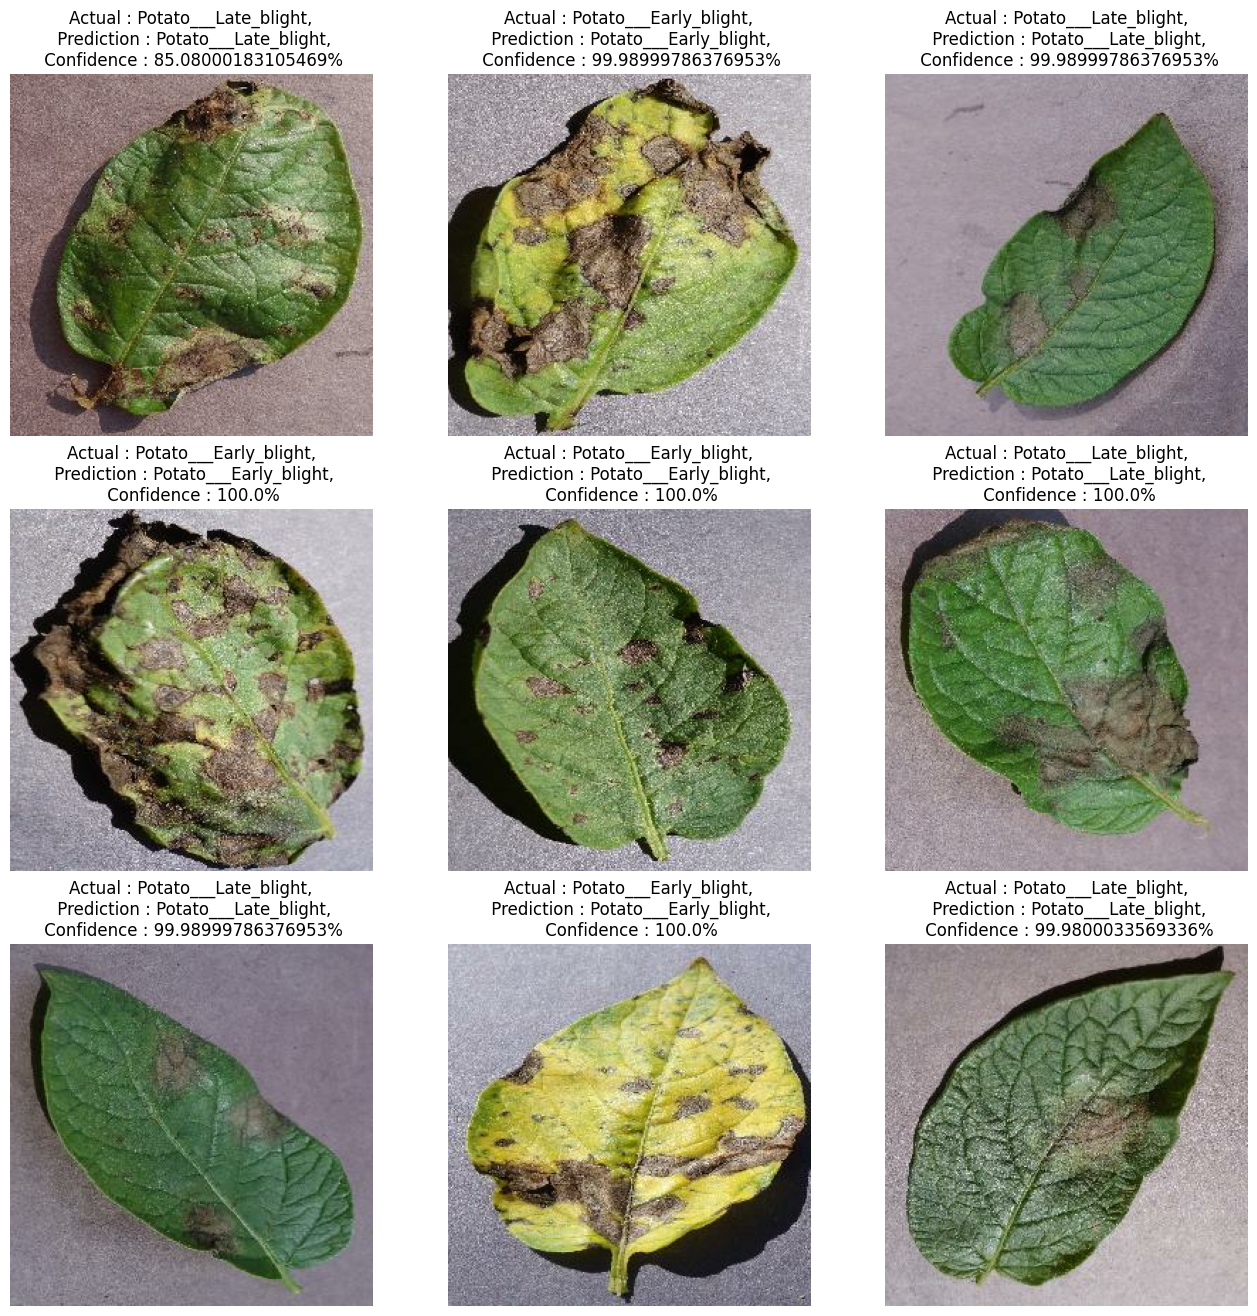

In [31]:
# plotting batch of images with its actual label, predicted label and confidence
plt.figure(figsize = (16,16))
for batch_image, batch_label in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        image = batch_image[i].numpy().astype('uint8')
        label = class_name[batch_label[i]]
    
        plt.imshow(image)
    
        batch_prediction = model.predict(batch_image)
        predicted_class = class_name[np.argmax(batch_prediction[i])]
        confidence = round(np.max(batch_prediction[i]) * 100, 2)
        
        plt.title(f'Actual : {label},\n Prediction : {predicted_class},\n Confidence : {confidence}%')
    
        plt.axis('off')

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [33]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


                       precision    recall  f1-score   support

Potato___Early_blight       0.98      1.00      0.99       101
 Potato___Late_blight       1.00      0.98      0.99        81
     Potato___healthy       1.00      1.00      1.00        10

             accuracy                           0.99       192
            macro avg       0.99      0.99      0.99       192
         weighted avg       0.99      0.99      0.99       192



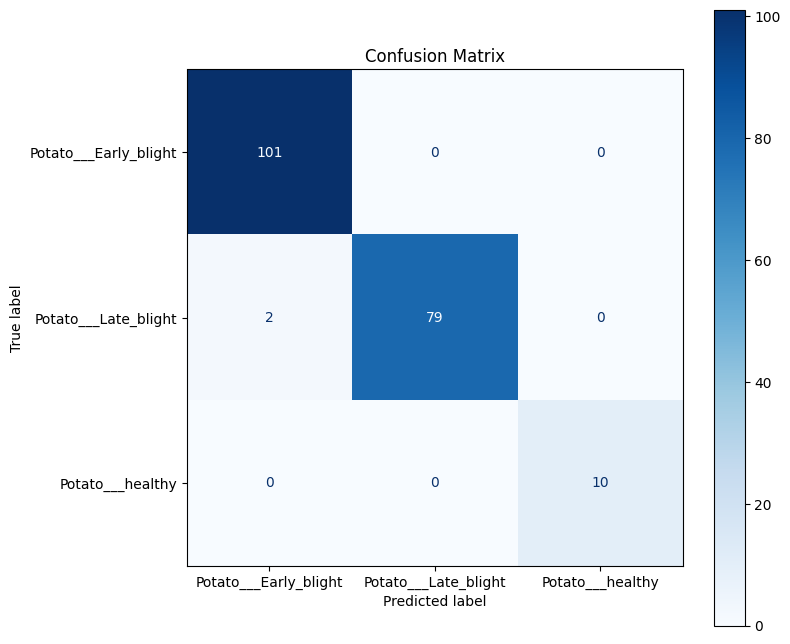

In [ ]:
# Daftar nama kelas
class_names = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']  # sesuaikan dengan dataset kamu

# Hitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']))

# Visualisasi confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=True)
plt.title('Confusion Matrix')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


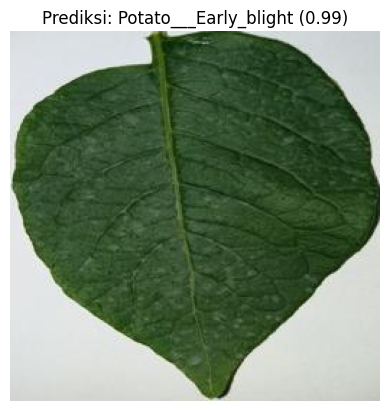

In [57]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Daftar kelas (urutan sama seperti pada training)
class_names = ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

def predict_custom_image(image_path):
    # Load dan ubah ukuran gambar sesuai input model
    img = load_img(image_path, target_size=(256, 256))
    img_array = img_to_array(img) / 255.0  # Normalisasi
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan batch dimension

    # Prediksi
    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class_index]
    confidence = prediction[0][predicted_class_index]

    # Tampilkan hasil
    plt.imshow(img)
    plt.title(f"Prediksi: {predicted_class_name} ({confidence:.2f})")
    plt.axis('off')
    plt.show()

predict_custom_image("../new_images/Healthy.jpg")

In [35]:
from PIL import Image


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


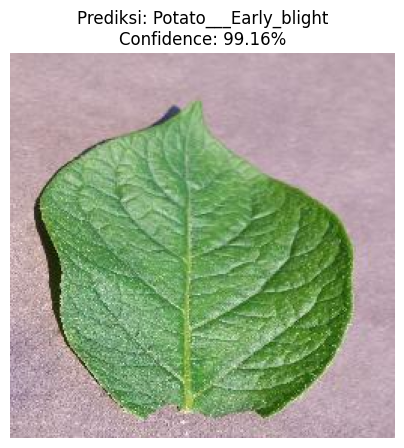

In [40]:
from tensorflow.keras.utils import load_img, img_to_array
import os

# Ganti dengan path file gambar baru
new_image_path = 'D:/Semester 6/AI/Artificial_Inteligence/new_images/Potato4.jpeg'

# Fungsi prediksi
def predict_new_image(model, image_path, class_names, img_size):
    # Load dan preprocess gambar
    img = load_img(image_path, target_size=(img_size, img_size))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalisasi
    img_array = np.expand_dims(img_array, axis=0)  # Ubah jadi batch (1, 256, 256, 3)

    # Prediksi
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions)
    confidence = np.max(predictions) * 100

    predicted_label = class_names[predicted_index]
    return predicted_label, confidence, img

# Panggil fungsi prediksi
predicted_class, confidence, original_image = predict_new_image(model, new_image_path, class_name, Image_Size)

# Tampilkan hasil
plt.figure(figsize=(5, 5))
plt.imshow(original_image)
plt.axis('off')
plt.title(f"Prediksi: {predicted_class}\nConfidence: {confidence:.2f}%")
plt.show()


In [41]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
from PIL import Image

def predict_new_image(model, image_path, class_names, image_size=256):
    # Load dan resize gambar sesuai input model
    img = load_img(image_path, target_size=(image_size, image_size))
    
    # Konversi gambar ke array numpy dan normalisasi pixel ke [0,1]
    img_array = img_to_array(img) / 255.0
    
    # Tambahkan dimensi batch karena model expect batch input
    img_array = np.expand_dims(img_array, axis=0)
    
    # Prediksi kelas
    predictions = model.predict(img_array)
    
    # Ambil indeks kelas dengan probabilitas tertinggi
    predicted_index = np.argmax(predictions[0])
    confidence = predictions[0][predicted_index] * 100
    
    # Tampilkan gambar dan hasil prediksi
    plt.imshow(img)
    plt.title(f"Prediksi: {class_names[predicted_index]} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()
    
    return class_names[predicted_index], confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


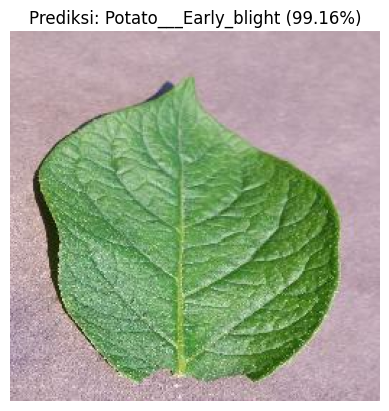

Prediksi kelas: Potato___Early_blight dengan confidence 99.16%


In [46]:
# Ganti dengan path file gambar baru yang ingin diprediksi
new_image_path = r'D:\Semester 6\AI\Artificial_Inteligence\new_images\Potato4.jpeg'

predicted_class, confidence = predict_new_image(model, new_image_path, class_name, Image_Size)
print(f"Prediksi kelas: {predicted_class} dengan confidence {confidence:.2f}%")


In [47]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array

def predict_new_image(model, image_path, class_names, image_size=256):
    # Load gambar dengan PIL dan resize
    img = Image.open(image_path).resize((image_size, image_size))
    
    # Konversi ke array dan normalisasi
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi
    predictions = model.predict(img_array)
    predicted_index = np.argmax(predictions[0])
    confidence = predictions[0][predicted_index] * 100

    # Tampilkan hasil prediksi
    plt.imshow(img)
    plt.title(f"Prediksi: {class_names[predicted_index]} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

    return class_names[predicted_index], confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


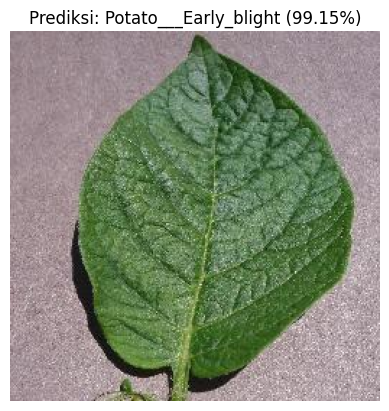

Prediksi kelas: Potato___Early_blight dengan confidence 99.15%


In [48]:
new_image_path = r'D:\Semester 6\AI\Artificial_Inteligence\new_images\Potato.jpg'

predicted_class, confidence = predict_new_image(model, new_image_path, class_name, Image_Size)
print(f"Prediksi kelas: {predicted_class} dengan confidence {confidence:.2f}%")


In [124]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_image_cv2(model, image_path, class_names, image_size=256):
    img = cv2.imread(image_path)  # baca gambar (BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # konversi ke RGB
    img = cv2.resize(img, (image_size, image_size))  # resize
    img = img / 255.0  # normalisasi
    img_array = np.expand_dims(img, axis=0)  # batch dim
    
    prediction = model.predict(img_array)
    pred_index = np.argmax(prediction[0])
    confidence = prediction[0][pred_index] * 100
    
    plt.imshow(img)
    plt.title(f"Prediksi: {class_names[pred_index]} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()
    
    return class_names[pred_index], confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


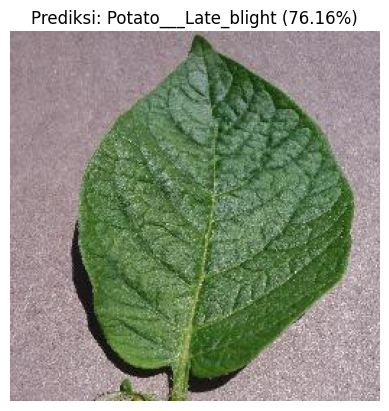

Prediksi kelas: Potato___Late_blight dengan confidence 76.16%


In [125]:
image_path = 'D:/Semester 6/AI/Artificial_Inteligence/new_images/Potato.jpg'
predicted_class, confidence = predict_image_cv2(model, image_path, class_name, Image_Size)
print(f"Prediksi kelas: {predicted_class} dengan confidence {confidence:.2f}%")